In [63]:
from collections import namedtuple, defaultdict, Counter
import json
import numpy as np
import matplotlib.pyplot as plt
import random
from os import listdir
import scipy.stats as stats

In [73]:
#data_dir = '../../DATA/platinum'
#haplotype_file = '../data/GenotypeFiles/haplotype_transmission_hg19.txt'

data_dir = '../../DATA/platinum_sim'
haplotype_file = '../simulation/simulated_genomes/simulated_haplotype_transmission_hg19.txt'

Crossover = namedtuple('Crossover', 
                       ['family', 'chrom', 'start_pos', 'end_pos', 
                        'child', 'is_mat', 'is_pat', 
                        'is_complex', 'is_hts'])

random.seed(35)
colors = ['#ef6c00ff', '#4db6acff', '#b3a77dff', '#695d46ff', '#ce93d8ff', '#009668ff', ]

In [74]:
with open('%s/phase/crossovers.json' % data_dir, 'r') as f:
    my_crossovers = [Crossover(x['family'], x['chrom'], x['start_pos'], x['end_pos'], \
                               x['child'], x['is_mat'], x['is_pat'], x['is_hts'], x['is_complex']) for x in json.load(f)]

random.shuffle(my_crossovers)

families_included = set()
siblings = set()
for x in my_crossovers:
    if x.family not in families_included and x.child[0] not in siblings and x.child[1] not in siblings:
        families_included.add(x.family)
        siblings.add(x.child[0])
        siblings.add(x.child[1])
        
my_crossovers = [x for x in my_crossovers if x.family in families_included]
print('crossovers', len(my_crossovers), np.median([x.end_pos - x.start_pos for x in my_crossovers]))

siblings = sorted(set([x.child[0] for x in my_crossovers]) | set([x.child[1] for x in my_crossovers]))
print('siblings', len(siblings))


crossovers 288 5928.0
siblings 96


In [75]:


platinum_crossovers = []

# pull actual crossovers
prev_line = None
with open(haplotype_file, 'r') as f:
    header = next(f).strip().split()
    for line in f:
        line = line.strip().split()
        
        if prev_line is not None and line[0] == prev_line[0] and line[0]!='chrX':
            for ind, cur, prev in zip(header[3:], line[3:], prev_line[3:]):
                if ind in siblings:
                    if cur[0] != prev[0]:
                        platinum_crossovers.append(Crossover('NA1281',
                                                    line[0][3:],
                                                    int(prev_line[2]),
                                                    int(line[1]),
                                                    ind,
                                                    False, True,
                                                    False, False
                                                   ))
                    if cur[1] != prev[1]:
                        platinum_crossovers.append(Crossover('NA1281',
                                                    line[0][3:],
                                                    int(prev_line[2]),
                                                    int(line[1]),
                                                    ind,
                                                    True, False,
                                                    False, False
                                                   ))
        prev_line = line
print(len(platinum_crossovers))
                    
chrom_to_platinum_crossovers = defaultdict(list)
for x in platinum_crossovers:
    chrom_to_platinum_crossovers[x.chrom].append(x)
    
platinum_crossover_to_index = dict([(x, i) for i, x in enumerate(platinum_crossovers)])


291


In [76]:
my_has_match = np.zeros((len(my_crossovers),), dtype=bool)
platinum_has_match = np.zeros((len(platinum_crossovers),), dtype=bool)
my_matches = [[] for _ in my_crossovers]
platinum_matches = [[] for _ in platinum_crossovers]
my_is_mat = np.array([x.is_mat for x in my_crossovers])
platinum_is_mat = np.array([x.is_mat for x in platinum_crossovers])

e = 10**5
for i, co in enumerate(my_crossovers):
    overlap = [x for x in chrom_to_platinum_crossovers[co.chrom] if (x.start_pos <= co.end_pos+e) and (co.start_pos-e <= x.end_pos) and (x.child in co.child) and (x.is_mat == co.is_mat)]
    if len(overlap)>0:
        my_has_match[i] = True
        my_matches[i] = overlap
        for x in overlap:
            platinum_has_match[platinum_crossover_to_index[x]] = True
            platinum_matches[platinum_crossover_to_index[x]].append(co)
            

print(np.sum(my_has_match)/len(my_has_match))
print(np.sum(platinum_has_match)/len(platinum_has_match))

print('precision', np.sum(my_has_match)/len(my_has_match))
print('recall', np.sum(platinum_has_match)/len(platinum_has_match))
  
print('\nmaternal precision', np.sum(my_has_match & my_is_mat)/np.sum(my_is_mat))
print('maternal recall', np.sum(platinum_has_match & platinum_is_mat)/np.sum(platinum_is_mat))

print('\npaternal precision', np.sum(my_has_match & ~my_is_mat)/np.sum(~my_is_mat))
print('paternal recall', np.sum(platinum_has_match & ~platinum_is_mat)/np.sum(~platinum_is_mat))
    

0.9340277777777778
0.9243986254295533
precision 0.9340277777777778
recall 0.9243986254295533

maternal precision 0.9383886255924171
maternal recall 0.9339622641509434

paternal precision 0.922077922077922
paternal recall 0.8987341772151899


In [77]:
for y in range(4):
    pass
print(y)

3


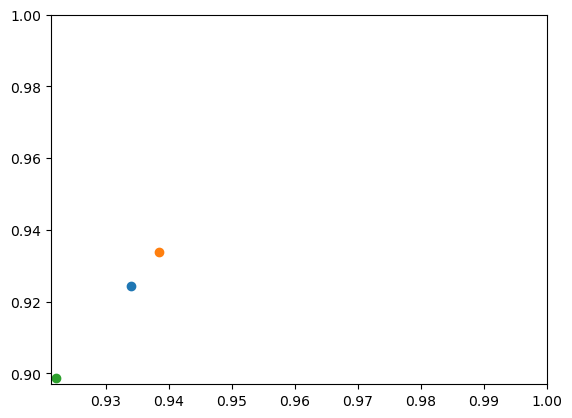

In [78]:
plt.scatter([np.sum(my_has_match)/len(my_has_match)], [np.sum(platinum_has_match)/len(platinum_has_match)])
plt.scatter([np.sum(my_has_match & my_is_mat)/np.sum(my_is_mat)], [np.sum(platinum_has_match & platinum_is_mat)/np.sum(platinum_is_mat)])
plt.scatter([np.sum(my_has_match & ~my_is_mat)/np.sum(~my_is_mat)], [np.sum(platinum_has_match & ~platinum_is_mat)/np.sum(~platinum_is_mat)])
plt.xlim([None, 1])
plt.ylim([None, 1])
plt.show()



Chi2ContingencyResult(statistic=0.050779002687394714, pvalue=0.8217132531264095, dof=1, expected_freq=array([[197.07986111,  71.92013889],
       [ 13.92013889,   5.07986111]]))


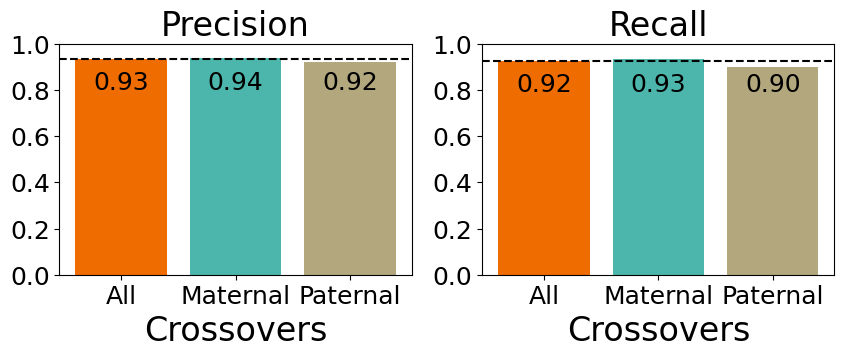

In [79]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
data = [np.sum(my_has_match)/len(my_has_match), 
                   np.sum(my_has_match & my_is_mat)/np.sum(my_is_mat),
                   np.sum(my_has_match & ~my_is_mat)/np.sum(~my_is_mat)]
plt.bar([0, 1, 2], data,
       color=colors[:3])
for i in range(3):
    plt.text(i, data[0]-0.05, '%0.2f' % data[i], 
             fontsize=18, horizontalalignment='center', verticalalignment='top', color='black' if i<3 else 'white')

plt.title('Precision', fontsize=24)
plt.ylim([0, 1])
plt.yticks(fontsize=18)
plt.xticks([0, 1, 2], ['All', 'Maternal', 'Paternal'], fontsize=18)
plt.xlabel('Crossovers', fontsize=24)
plt.axhline(np.sum(my_has_match)/len(my_has_match), color='black', linestyle='--')

plt.subplot(1, 2, 2)
data = [np.sum(platinum_has_match)/len(platinum_has_match), 
                   np.sum(platinum_has_match & platinum_is_mat)/np.sum(platinum_is_mat),
                   np.sum(platinum_has_match & ~platinum_is_mat)/np.sum(~platinum_is_mat)]
plt.bar([0, 1, 2], data,
       color=colors[:3])
for i in range(3):
    plt.text(i, data[0]-0.05, '%0.2f' % data[i], 
             fontsize=18, horizontalalignment='center', verticalalignment='top', color='black' if i<3 else 'white')

plt.title('Precision', fontsize=24)
plt.ylim([0, 1])
plt.yticks(fontsize=18)
plt.xticks([0, 1, 2], ['All', 'Maternal', 'Paternal'], fontsize=18)
plt.xlabel('Crossovers', fontsize=24)
plt.axhline(np.sum(platinum_has_match)/len(platinum_has_match), color='black', linestyle='--')

plt.title('Recall', fontsize=24)

if data_dir == '../../DATA/platinum':
    plt.savefig('../plots/platinum.png', bbox_inches="tight")
    plt.savefig('../plots/Fig_1.png', bbox_inches="tight")
elif data_dir == '../../DATA/platinum_sim':
    plt.savefig('../plots/platinum_sim.png', bbox_inches="tight")
    plt.savefig('../plots/Fig_2.png', bbox_inches="tight")
    
print(stats.chi2_contingency([[np.sum(my_has_match & my_is_mat), np.sum(my_has_match & ~my_is_mat)],
                              [np.sum(~my_has_match & my_is_mat), np.sum(~my_has_match & ~my_is_mat)]]))

#print(stats.chi2_contingency([[np.sum(platinum_has_match & platinum_is_mat), np.sum(platinum_has_match & ~platinum_is_mat)],
#                              [np.sum(~platinum_has_match & platinum_is_mat), np.sum(~platinum_has_match & ~platinum_is_mat)]]))

In [80]:
print([x for x, m in zip(platinum_crossovers, platinum_has_match) if not m])

[Crossover(family='NA1281', chrom='10', start_pos=4440625, end_pos=4441745, child='NA12888_NA12880_False_True', is_mat=False, is_pat=True, is_complex=False, is_hts=False), Crossover(family='NA1281', chrom='10', start_pos=4440625, end_pos=4441745, child='NA12888_NA12879_True_False', is_mat=False, is_pat=True, is_complex=False, is_hts=False), Crossover(family='NA1281', chrom='10', start_pos=6553634, end_pos=6556041, child='NA12888_NA12888_True_False', is_mat=True, is_pat=False, is_complex=False, is_hts=False), Crossover(family='NA1281', chrom='10', start_pos=6553634, end_pos=6556041, child='NA12881_NA12888_True_False', is_mat=True, is_pat=False, is_complex=False, is_hts=False), Crossover(family='NA1281', chrom='10', start_pos=21639081, end_pos=21639837, child='NA12879_NA12882_True_False', is_mat=True, is_pat=False, is_complex=False, is_hts=False), Crossover(family='NA1281', chrom='10', start_pos=21639081, end_pos=21639837, child='NA12885_NA12882_False_True', is_mat=True, is_pat=False, is

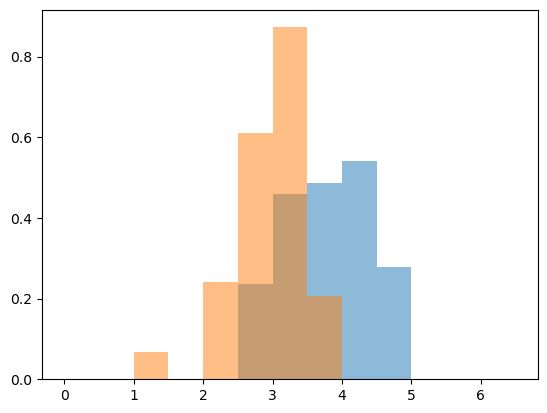

In [81]:
plt.hist(np.log10([co.end_pos - co.start_pos for co in my_crossovers]), alpha = 0.5, density=True, bins=np.arange(0, 7, 0.5))
plt.hist(np.log10([x.end_pos - x.start_pos for x in platinum_crossovers]), alpha = 0.5, density=True, bins=np.arange(0, 7, 0.5))
plt.show()

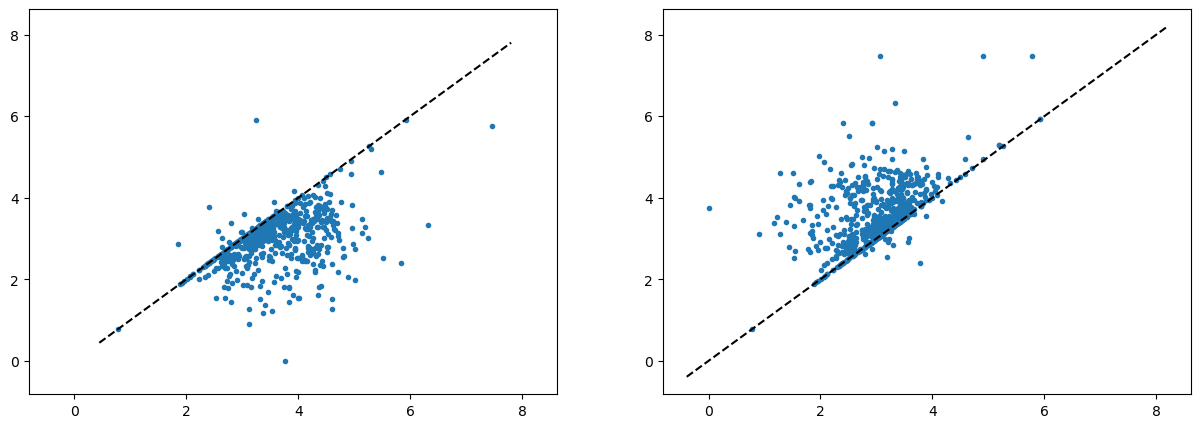

In [11]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.scatter(np.log10([co.end_pos - co.start_pos for (co, ms) in zip(my_crossovers, my_matches) if len(ms)>0]),
            np.log10([1 if len(ms)==0 else ms[0].end_pos - ms[0].start_pos for ms in my_matches if len(ms)>0]), marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle = '--')

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.scatter(np.log10([x.end_pos - x.start_pos for (x, ms) in zip(platinum_crossovers, platinum_matches) if len(ms)>0]),
            np.log10([1 if len(ms)==0 else ms[0].end_pos - ms[0].start_pos for ms in platinum_matches if len(ms)>0]), marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle = '--')
plt.show()

In [17]:
sibpairs = []
mat_frac = []
pat_frac = []

for filename in listdir('../../DATA/platinum/phase/inheritance_patterns'):
    if filename.endswith('.phased.bed'):
        siblings = filename.split('.')[-4:-2]
        print(siblings)
        family = 'NA1281.%s.%s' % tuple(siblings)
        
        mat_num, mat_denom = 0, 0
        pat_num, pat_denom = 0, 0

        for i, chrom in enumerate([str(x) for x in range(1, 23)]):
            # first, pull positions

            positions = set()
            with open('../data/GenotypeFiles/haplotype_transmission_hg19.txt', 'r') as f:
                header = next(f).strip().split()
                #sib_indices = [i for i, x in enumerate(header) if x in siblings]
                for line in f:
                    line = line.strip().split()

                    if line[0][3:] == chrom:
                        positions.add(int(line[1]))
                        positions.add(int(line[2]))

            with open('../../DATA/platinum/phase/inheritance_patterns/%s.phased.bed' % family, 'r') as f:
                header = next(f).strip().split()
                for line in f:
                    line = line.strip().split()

                    if line[0][3:] == chrom:
                        positions.add(int(line[1]))
                        positions.add(int(line[2]))

            positions = sorted(positions)

            # next, pull inheritance pattern
            pos_to_index = dict([(x, i) for i, x in enumerate(positions)])

            mat_match_platinum = -np.ones((len(positions),), dtype=int)
            pat_match_platinum = -np.ones((len(positions),), dtype=int)
            with open('../data/GenotypeFiles/haplotype_transmission_hg19.txt', 'r') as f:
                header = next(f).strip().split()
                sib_indices = [i for i, x in enumerate(header) if x in siblings]
                for line in f:
                    line = line.strip().split()

                    if line[0][3:] == chrom:
                        mat_match_platinum[pos_to_index[int(line[1])]:pos_to_index[int(line[2])]] = line[sib_indices[0]][1] == line[sib_indices[1]][1]
                        pat_match_platinum[pos_to_index[int(line[1])]:pos_to_index[int(line[2])]] = line[sib_indices[0]][0] == line[sib_indices[1]][0]


            mat_match_phase = -np.ones((len(positions),), dtype=int)
            pat_match_phase = -np.ones((len(positions),), dtype=int) 
            with open('../../DATA/platinum/phase/inheritance_patterns/%s.phased.bed' % family, 'r') as f:
                header = next(f).strip().split()
                sib_mat_indices = [i for i, x in enumerate(header) if x in ['%s_mat' % siblings[0], '%s_mat' % siblings[1]]]
                sib_pat_indices = [i for i, x in enumerate(header) if x in ['%s_pat' % siblings[0], '%s_pat' % siblings[1]]]
                for line in f:
                    line = line.strip().split()

                    if line[0][3:] == chrom and line[-1]=='0':
                        if line[sib_mat_indices[0]] != '-1' and line[sib_mat_indices[1]] != '-1':
                            mat_match_phase[pos_to_index[int(line[1])]:pos_to_index[int(line[2])]] = line[sib_mat_indices[0]] == line[sib_mat_indices[1]]
                        if line[sib_pat_indices[0]] != '-1' and line[sib_pat_indices[1]] != '-1':
                            pat_match_phase[pos_to_index[int(line[1])]:pos_to_index[int(line[2])]] = line[sib_pat_indices[0]] == line[sib_pat_indices[1]]

            lengths = np.array(positions[1:])-np.array(positions[:-1])
            mat_num += np.sum(lengths[(mat_match_platinum[:-1]!=-1) & (mat_match_phase[:-1]!=-1) & (mat_match_platinum[:-1]==mat_match_phase[:-1])])
            mat_denom += np.sum(lengths[(mat_match_platinum[:-1]!=-1) & (mat_match_phase[:-1]!=-1)])
            pat_num += np.sum(lengths[(pat_match_platinum[:-1]!=-1) & (pat_match_phase[:-1]!=-1) & (pat_match_platinum[:-1]==pat_match_phase[:-1])])
            pat_denom += np.sum(lengths[(pat_match_platinum[:-1]!=-1) & (pat_match_phase[:-1]!=-1)])
            
        sibpairs.append(siblings)
        mat_frac.append(mat_num/mat_denom)
        pat_frac.append(pat_num/pat_denom)


['NA12883', 'NA12885']
['NA12882', 'NA12886']
['NA12886', 'NA12887']
['NA12881', 'NA12883']
['NA12888', 'NA12893']
['NA12885', 'NA12893']
['NA12883', 'NA12888']
['NA12879', 'NA12886']
['NA12886', 'NA12893']
['NA12880', 'NA12888']
['NA12879', 'NA12883']
['NA12882', 'NA12883']
['NA12880', 'NA12885']
['NA12885', 'NA12887']
['NA12881', 'NA12886']
['NA12880', 'NA12882']
['NA12883', 'NA12887']
['NA12882', 'NA12884']
['NA12879', 'NA12884']
['NA12886', 'NA12888']
['NA12880', 'NA12893']
['NA12885', 'NA12888']
['NA12883', 'NA12893']
['NA12879', 'NA12881']
['NA12884', 'NA12886']
['NA12880', 'NA12887']
['NA12881', 'NA12884']
['NA12879', 'NA12882']
['NA12882', 'NA12893']
['NA12884', 'NA12888']
['NA12879', 'NA12893']
['NA12885', 'NA12886']
['NA12881', 'NA12887']
['NA12884', 'NA12885']
['NA12880', 'NA12884']
['NA12882', 'NA12887']
['NA12883', 'NA12884']
['NA12880', 'NA12881']
['NA12881', 'NA12882']
['NA12881', 'NA12893']
['NA12887', 'NA12888']
['NA12879', 'NA12887']
['NA12879', 'NA12880']
['NA12881',

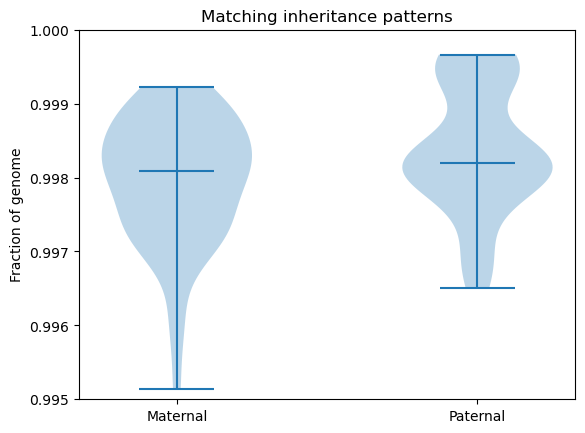

In [18]:
plt.violinplot([mat_frac, pat_frac], showmedians=True)
plt.ylim([0.995, 1.0])
plt.xticks([1, 2], ['Maternal', 'Paternal'])
plt.ylabel('Fraction of genome')
plt.title('Matching inheritance patterns')
plt.show()

# differences may be due to complex gene conversions which happen more often in female meiosis

In [19]:
print(np.median(mat_frac), np.median(pat_frac))

0.998093192518305 0.9981978199957996


# Directly compare inheritance pattern

In [12]:
#siblings = ['NA12879', 'NA12888']
#family = 'NA1281.%s.%s' % tuple(siblings[:2])

siblings =["NA12881_NA12888_True_False",
        "NA12888_NA12888_True_False"]
family = 'NA1281_sim12'

In [13]:
plt.figure(figsize=(15, 50))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def plot_inh(x, index):
    change_indices = np.where(x[1:] != x[:-1])[0]
    prev_index = 0
    for change in change_indices:
        plt.plot([positions[prev_index], positions[change+1]], [index, index], linewidth=20,
                 color=[colors[0], colors[1], 'black'][x[change]])
        prev_index = change+1


for i, chrom in enumerate([str(x) for x in range(1, 23)]):
    # first, pull positions

    positions = set()
    with open(haplotype_file, 'r') as f:
        header = next(f).strip().split()
        #sib_indices = [i for i, x in enumerate(header) if x in siblings]
        for line in f:
            line = line.strip().split()

            if line[0][3:] == chrom:
                positions.add(int(line[1]))
                positions.add(int(line[2]))

    with open('%s/phase/inheritance_patterns/%s.phased.bed' % (data_dir, family), 'r') as f:
        header = next(f).strip().split()
        for line in f:
            line = line.strip().split()

            if line[0][3:] == chrom:
                positions.add(int(line[1]))
                positions.add(int(line[2]))

    positions = sorted(positions)
    print('pos', len(positions))
    
    # next, pull inheritance pattern
    pos_to_index = dict([(x, i) for i, x in enumerate(positions)])

    mat_match_platinum = -np.ones((len(positions),), dtype=int)
    pat_match_platinum = -np.ones((len(positions),), dtype=int)
    with open(haplotype_file, 'r') as f:
        header = next(f).strip().split()
        sib_indices = [i for i, x in enumerate(header) if x in siblings]
        for line in f:
            line = line.strip().split()

            if line[0][3:] == chrom:
                mat_match_platinum[pos_to_index[int(line[1])]:pos_to_index[int(line[2])]] = line[sib_indices[0]][1] == line[sib_indices[1]][1]
                pat_match_platinum[pos_to_index[int(line[1])]:pos_to_index[int(line[2])]] = line[sib_indices[0]][0] == line[sib_indices[1]][0]


    mat_match_phase = -np.ones((len(positions),), dtype=int)
    pat_match_phase = -np.ones((len(positions),), dtype=int) 
    with open('%s/phase/inheritance_patterns/%s.phased.bed' % (data_dir, family), 'r') as f:
        header = next(f).strip().split()
        sib_mat_indices = [i for i, x in enumerate(header) if x in ['%s_mat' % siblings[0], '%s_mat' % siblings[1]]]
        sib_pat_indices = [i for i, x in enumerate(header) if x in ['%s_pat' % siblings[0], '%s_pat' % siblings[1]]]
        for line in f:
            line = line.strip().split()

            if line[0][3:] == chrom and line[-1]=='0':
                if line[sib_mat_indices[0]] != '-1' and line[sib_mat_indices[1]] != '-1':
                    mat_match_phase[pos_to_index[int(line[1])]:pos_to_index[int(line[2])]] = line[sib_mat_indices[0]] == line[sib_mat_indices[1]]
                if line[sib_pat_indices[0]] != '-1' and line[sib_pat_indices[1]] != '-1':
                    pat_match_phase[pos_to_index[int(line[1])]:pos_to_index[int(line[2])]] = line[sib_pat_indices[0]] == line[sib_pat_indices[1]]

    plt.subplot(22, 1, i+1)
    plot_inh(mat_match_platinum, 3)
    plot_inh(mat_match_phase, 2)
    plot_inh(pat_match_platinum, 1)
    plot_inh(pat_match_phase, 0)
    
    lengths = np.array(positions[1:])-np.array(positions[:-1])
    print('mat match', np.sum(lengths[(mat_match_platinum[:-1]!=-1) & (mat_match_phase[:-1]!=-1) & (mat_match_platinum[:-1]==mat_match_phase[:-1])])/np.sum(lengths[(mat_match_platinum[:-1]!=-1) & (mat_match_phase[:-1]!=-1)]))
    print('pat match', np.sum(lengths[(pat_match_platinum[:-1]!=-1) & (pat_match_phase[:-1]!=-1) & (pat_match_platinum[:-1]==pat_match_phase[:-1])])/np.sum(lengths[(pat_match_platinum[:-1]!=-1) & (pat_match_phase[:-1]!=-1)]))

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../DATA/platinum/phase/inheritance_patterns/NA1281_sim12.phased.bed'

<Figure size 1500x5000 with 0 Axes>